# Etapa 4 - Deep Learning

## Carla Rafaela Silva, pg42862; José Pereira, pg42871; Tiago Silva, pg42885.

In [1]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from loaders.Loaders import CSVLoader
from splitters.splitters import SingletaskStratifiedSplitter
# from metrics.Metrics import Metric
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, matthews_corrcoef, precision_score)
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise, Conv1D, Flatten, Reshape, LSTM, Bidirectional
# from models.kerasModels import KerasModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scalers.sklearnScalers import StandardScaler

import tensorflow as tf
print(tf.version.VERSION)

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

warnings.filterwarnings('ignore')

2.7.0


# CHECK GPU

Condition to check and enable GPU (Graphics Processing Unit) usage when training the deep learning models.

In [2]:
tf.config.experimental.list_physical_devices('GPU')

2022-01-27 16:17:23.795051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 16:17:23.827974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 16:17:23.828819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Using GPU: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Num GPUs Available:  1
Using GPU: /device:GPU:0


2022-01-27 16:17:23.845938: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-27 16:17:23.847955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 16:17:23.848796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 16:17:23.849400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Support functions

In [4]:
def metrics(label_test, predict):
    print('METRICS:')
    print(f"Accuracy score:\n{accuracy_score(label_test, predict)}\n")
    print(f"Recall score:\n{recall_score(label_test, predict, average='macro')}\n")
    print(f"Precison score:\n{precision_score(label_test, predict, average='macro', zero_division=0)}\n")
    print(f"F1-score:\n{f1_score(label_test, predict, average='macro')}\n")
    print(f"MCC score:\n{matthews_corrcoef(label_test, predict)}\n")
    print(f"Confusion matrix:\n{confusion_matrix(label_test, predict)}\n")
    print(f"Classification report:\n{classification_report(label_test, predict, zero_division=0, digits=3)}\n")

The ***metrics*** function receives the true labels for the test set and the labels predicted by the model, and it computes all the relevant metrics and the confusion matrix.
It also has an optional argument that indicates if we want to use regression or not. If we use regression, the function will show metrics only for regression.

Classification scores:
**Accuracy score**: Fraction of the prediction the model got right. The best value is 1, and the worst value is 0.
**Recall score**: The recall is the ability of the classifier to find all the positive samples. The best value is 1, and the worst value is 0.
**Precision score**: The precision is the ability of the classifier not to label as positive a sample that is negative. The best value is 1, and the worst value is 0.
**F1-score**: The F1 score can be interpreted as a harmonic mean of the precision and recall. The best value is 1, and the worst value is 0.
**MCC score**: Measure the quality of binary and multiclass classifications. The MCC is, in essence, a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 is an average random prediction, and -1 is an inverse prediction.

In [5]:
early = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

The condiction which the model uses when training that allows the training procedure to stop when the validation loss does not decrease on 15 consecutive epochs.

# Fingerprints

In [6]:
rdk_path = '/home/laptop16/Desktop/Mestrado/2_ano/SIB/Grupo/CODE_SIB/src/smiles/dataset/binary_class/rdk_fs_all.csv'

bits = [0,5,25,34,36,55,77,78,101,103,105,106,113,117,128,129,142,175,188,194,195,196,197,200,203,211,231,270,274,278,281,291,309,335,365,382,386,388,400,406,411,419,427,438,443,461,471,492,498,515,516,522,532,549,563,586,589,594,608,620,632,636,640,668,671,674,676,684,697,701,704,707,719,728,734,738,742,759,779,791,798,799,838,841,847,853,857,865,870,876,883,887,927,935,940,955,962,972,985,992,1016,1024,1037,1043,1045,1051,1072,1097,1104,1113,1123,1130,1133,1134,1145,1155,1180,1184,1222,1238,1255,1265,1287,1288,1295,1302,1305,1338,1341,1342,1346,1347,1369,1374,1375,1377,1389,1400,1403,1420,1421,1451,1456,1472,1479,1483,1492,1494,1500,1501,1520,1522,1528,1533,1536,1542,1545,1548,1556,1579,1599,1605,1612,1652,1656,1667,1670,1672,1676,1681,1682,1685,1686,1699,1705,1707,1727,1732,1734,1771,1778,1792,1818,1820,1823,1832,1846,1849,1861,1867,1872,1876,1885,1889,1892,1915,1921,1931,1942,1971,1973,1992,1995,2003,2041]

str_bits = list(str(x) for x in bits)

In [7]:
loader = CSVLoader(rdk_path, mols_field='smiles', labels_fields='activity', features_fields=str_bits)

In [8]:
dataset = loader.create_dataset()
dataset.get_shape()

Mols_shape:  39990
Features_shape:  (39990, 205)
Labels_shape:  (39990,)


## Data Split

Split the data into train and test subsets. The training set contains 70% of the total data.

In [9]:
splitter = SingletaskStratifiedSplitter()
# train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=dataset, frac_train=0.6, frac_valid=0.2, frac_test=0.2)
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset, frac_train=0.7)

input_dim = train_dataset.X.shape[1]

(27993, 205)
X not defined!
Defined features extracted!
(11997, 205)


## DNN

Dense Neural Network build with 2 dense hidden layers, a dense visible layer that functions as the input, and a final output layer.
The first layer, the input one, is a dense layer with 126 neurons. The second and third layers have 64 and 16 neurons respectively. These three layers have as activation function the ***rectified linear activation*** function, or ReLu. Between the first, second, and third layers the is a dropout layer with a dropout value of 0.1. This means that this layer drops 10% of the neurons output. The last layer has the purpose to provide the output and it has only one neuron. Since this is binary classification task, the activation function is the sigmoid function.

This neural network was compiled in order to use ***binary crossentropy*** as the loss function, the ***binary accuracy*** function as metric, and the ***Adam*** optimizer as the training algorithm.

In [10]:
dnn = Sequential()
dnn.add(Dense(126, input_dim=input_dim, activation='relu'))
dnn.add(Dropout(0.1))
dnn.add(Dense(64, activation='relu'))
dnn.add(Dropout(0.1))
dnn.add(Dense(16, activation='relu'))
dnn.add(Dense(1, activation='sigmoid'))
# Compile model
dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

2022-01-27 16:17:25.881046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 16:17:25.881682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 16:17:25.882143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 16:17:25.882613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 16:17:25.883607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [11]:
dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 126)               25956     
                                                                 
 dropout (Dropout)           (None, 126)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8128      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 35,141
Trainable params: 35,141
Non-traina

In [12]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_dnn = dnn.fit(train_dataset.X, train_dataset.y, validation_split=0.15, epochs=100, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27993, 205)
Train labels size: (27993,)
Epoch 1/100
744/744 [==============================] - 3s 3ms/step - loss: 0.5898 - binary_accuracy: 0.6885 - val_loss: 0.5974 - val_binary_accuracy: 0.7154
Epoch 2/100
744/744 [==============================] - 2s 3ms/step - loss: 0.5306 - binary_accuracy: 0.7350 - val_loss: 0.5449 - val_binary_accuracy: 0.7402
Epoch 3/100
744/744 [==============================] - 2s 3ms/step - loss: 0.4916 - binary_accuracy: 0.7591 - val_loss: 0.7069 - val_binary_accuracy: 0.6361
Epoch 4/100
744/744 [==============================] - 2s 3ms/step - loss: 0.4549 - binary_accuracy: 0.7854 - val_loss: 0.6253 - val_binary_accuracy: 0.6823
Epoch 5/100
744/744 [==============================] - 2s 3ms/step - loss: 0.4264 - binary_accuracy: 0.8034 - val_loss: 0.6082 - val_binary_accuracy: 0.7154
Epoch 6/100
744/744 [==============================] - 2s 3ms/step - loss: 0.3990 - binary_accuracy: 0.8184 - val_loss: 0.6345 - val_binary_accuracy: 0.7014


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


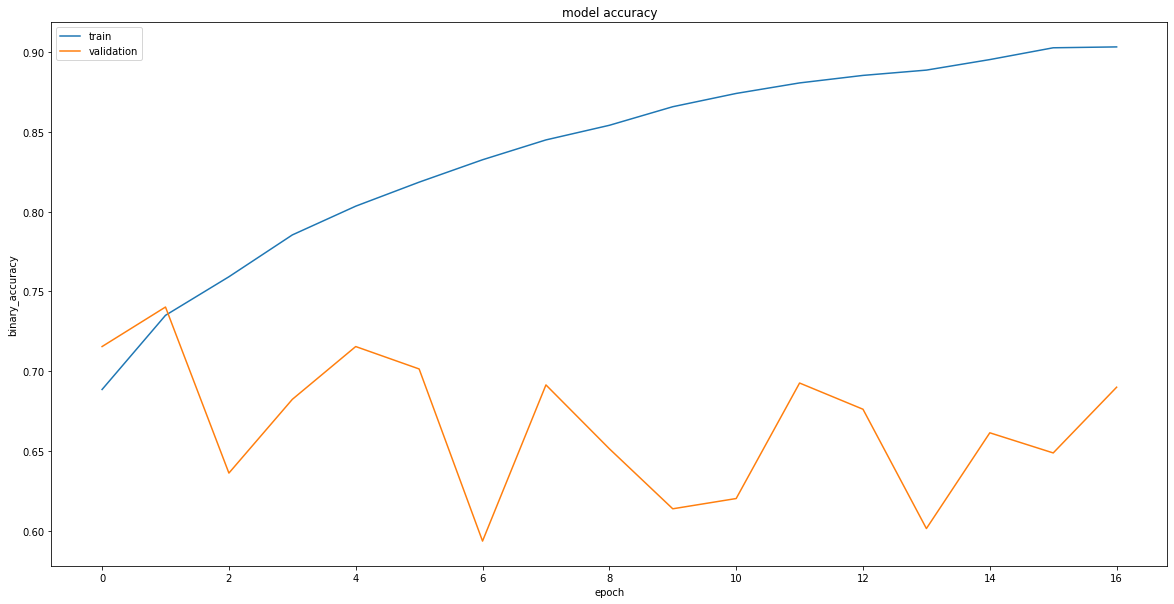

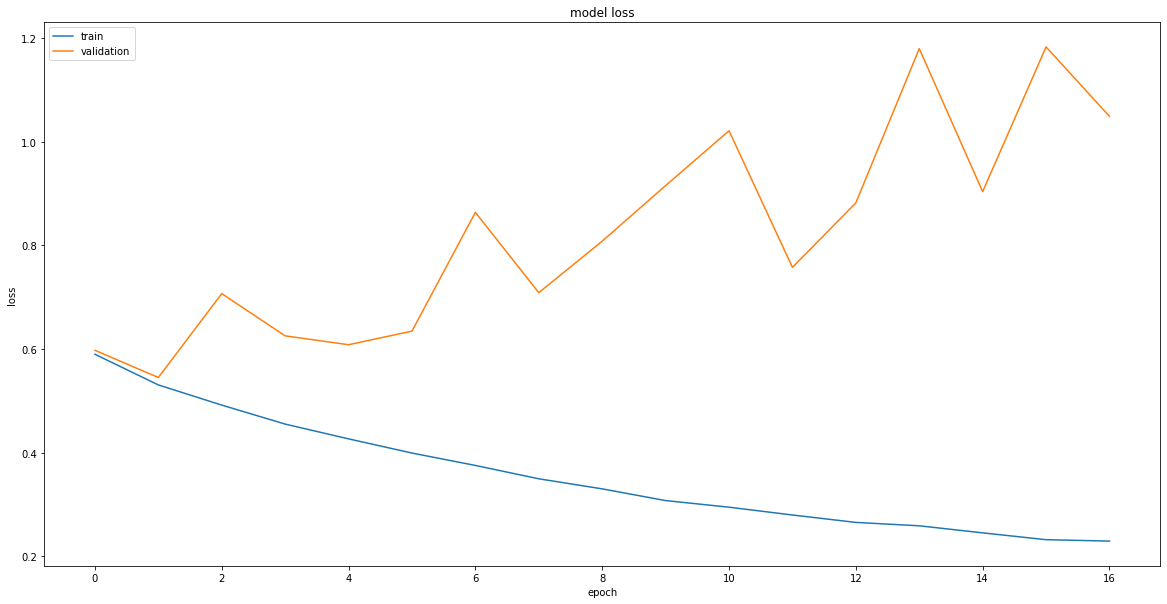

In [13]:
print(history_dnn.history.keys())
# summarize history for accuracy
plt.plot(history_dnn.history['binary_accuracy'])
plt.plot(history_dnn.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_dnn.history['loss'])
plt.plot(history_dnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
pred_dnn = dnn.predict(test_dataset.X)

In [15]:
pred_dnn_bin= np.where(pred_dnn >= 0.50, 1,0)

The function above is to transform the model output to the binary labels. The model's prediction returns the prediction fraction for the class labeled as "1". That way we said that each value greater or equal to 0.5 will become 1. This means that, if a sample has a probability greater or equal to 50% to be classified as "1" or "active", it will be labeled as "1". The other are classified has "0" or "inactive".

In [16]:
metrics(test_dataset.y, pred_dnn_bin)

METRICS:
Accuracy score:
0.769859131449529

Recall score:
0.7698568022979932

Precison score:
0.7707036256655456

F1-score:
0.769678469049355

MCC score:
0.5405597646609563

Confusion matrix:
[[4786 1213]
 [1548 4450]]

Classification report:
              precision    recall  f1-score   support

           0      0.756     0.798     0.776      5999
           1      0.786     0.742     0.763      5998

    accuracy                          0.770     11997
   macro avg      0.771     0.770     0.770     11997
weighted avg      0.771     0.770     0.770     11997




## CNN

This Convolutional Neural Network begins with a normalization layer. This layer adds ***Gaussian noise*** by applying a 0.05 standard deviation on the noise distribution. After this, there is a reshape layer that will transform the output to be in the shape (None, input dimension, 1). Then, the first real learning layers appears. They are two ***1D Convolutional*** (Conv1D) layers with ReLu activation function and ***same*** padding. The first of these layers has a filter value of 8 and the second has a filter valuo of 16. Both have a kernel size of 32. Then the Conv1D output is flatten and followed by a dropout layer with a value of 0.2. Lastly, there are two final dense layers. The second to last has 128 neurons and has the same activation funtion as the ones before. The final layer serves as the output layer and it has 1 neuron and the sigmoid activation function.
This neural network was compiled in order to use ***binary crossentropy*** as the loss function, the ***binary accuracy*** function as metric, and the ***Adam*** optimizer as the training algorithm.

In [17]:
g_noise = 0.05
C1_K=8
C1_S=32
C2_K=16
C2_S=32

In [18]:
cnn = Sequential()
#Adding a bit of GaussianNoise also works as regularization
cnn.add(GaussianNoise(g_noise, input_shape=(input_dim,)))
#First two is number of filter + kernel size
cnn.add(Reshape((input_dim, 1)))
cnn.add(Conv1D(C1_K, (C1_S), activation='relu', padding="same"))
cnn.add(Conv1D(C2_K, (C2_S), padding="same", activation='relu'))
cnn.add(Flatten())
cnn.add(Dropout(0.2))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [19]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 205)              0         
 se)                                                             
                                                                 
 reshape (Reshape)           (None, 205, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 205, 8)            264       
                                                                 
 conv1d_1 (Conv1D)           (None, 205, 16)           4112      
                                                                 
 flatten (Flatten)           (None, 3280)              0         
                                                                 
 dropout_2 (Dropout)         (None, 3280)              0         
                                                      

In [20]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_cnn = cnn.fit(train_dataset.X, train_dataset.y, validation_split=0.15, epochs=100, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27993, 205)
Train labels size: (27993,)
Epoch 1/100


2022-01-27 16:18:02.658091: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


744/744 [==============================] - 5s 4ms/step - loss: 0.5713 - binary_accuracy: 0.7030 - val_loss: 0.8081 - val_binary_accuracy: 0.4956
Epoch 2/100
744/744 [==============================] - 3s 4ms/step - loss: 0.5155 - binary_accuracy: 0.7451 - val_loss: 0.9540 - val_binary_accuracy: 0.4108
Epoch 3/100
744/744 [==============================] - 3s 4ms/step - loss: 0.4667 - binary_accuracy: 0.7793 - val_loss: 0.7964 - val_binary_accuracy: 0.5835
Epoch 4/100
744/744 [==============================] - 3s 4ms/step - loss: 0.4165 - binary_accuracy: 0.8072 - val_loss: 0.7106 - val_binary_accuracy: 0.5880
Epoch 5/100
744/744 [==============================] - 3s 4ms/step - loss: 0.3645 - binary_accuracy: 0.8384 - val_loss: 0.8803 - val_binary_accuracy: 0.5601
Epoch 6/100
744/744 [==============================] - 3s 4ms/step - loss: 0.3029 - binary_accuracy: 0.8705 - val_loss: 0.7689 - val_binary_accuracy: 0.6251
Epoch 7/100
744/744 [==============================] - 3s 4ms/step - l

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


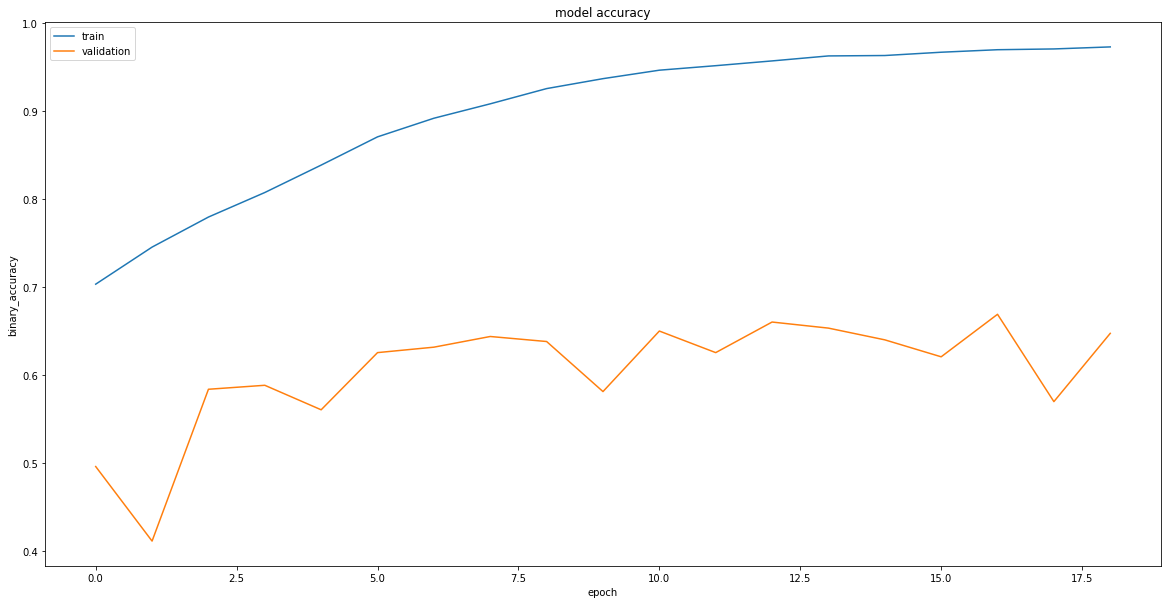

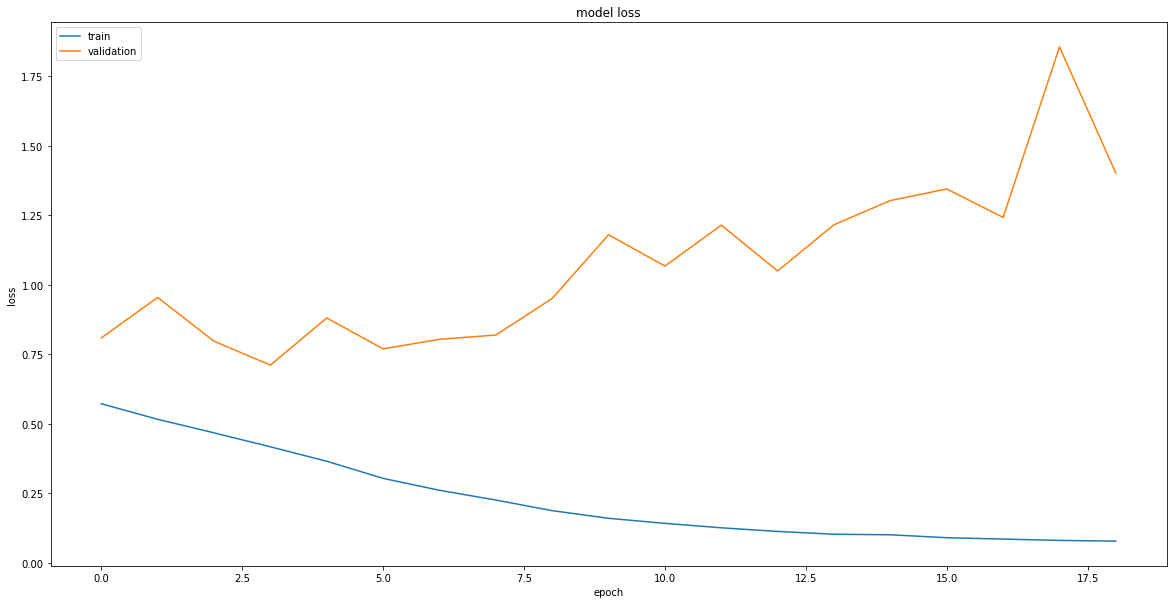

In [21]:
print(history_cnn.history.keys())
# summarize history for accuracy
plt.plot(history_cnn.history['binary_accuracy'])
plt.plot(history_cnn.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
pred_cnn = cnn.predict(test_dataset.X)

In [23]:
pred_cnn_bin = np.where(pred_cnn >= 0.50, 1, 0)

The function above is to transform the model output to the binary labels. The model's prediction returns the prediction fraction for the class labeled as "1". That way we said that each value greater or equal to 0.5 will become 1. This means that, if a sample has a probability greater or equal to 50% to be classified as "1" or "active", it will be labeled as "1". The other are classified has "0" or "inactive".

In [24]:
metrics(test_dataset.y, pred_cnn_bin)

METRICS:
Accuracy score:
0.7851962990747687

Recall score:
0.7851919690294054

Precison score:
0.7883068559347629

F1-score:
0.7846136029454871

MCC score:
0.5734903658430964

Confusion matrix:
[[5022  977]
 [1600 4398]]

Classification report:
              precision    recall  f1-score   support

           0      0.758     0.837     0.796      5999
           1      0.818     0.733     0.773      5998

    accuracy                          0.785     11997
   macro avg      0.788     0.785     0.785     11997
weighted avg      0.788     0.785     0.785     11997




## LSTM

Long Short-Term Memory (LSTM) is a recurrent neural network. This neural network has a LSTM layer as the visible layer. It has 128 neurons. This layer is followed by a 20% dropout layer. A second LSTM layer is added, with 64 neurons. After these, a 128 neuron deep dense layer appears followed, again, by a 20% dropout layer. Finally, a dense layer with sigmoid as the activation function, functions as the output layer.
This neural network was compiled in order to use ***binary crossentropy*** as the loss function, the ***binary accuracy*** function as metric, and the ***Adam*** optimizer as the training algorithm.

To note that the input data shape had to be transformed in order for this model to work. That way, the reshaped data has the following shape: (sample size, 1, features size).

In [25]:
x = np.reshape(train_dataset.X, (-1, 1, train_dataset.X.shape[1]))
y = np.reshape(train_dataset.y, (-1, 1, ))

In [26]:
xt = np.reshape(test_dataset.X, (-1, 1, test_dataset.X.shape[1]))
yt = np.reshape(test_dataset.y, (-1, 1, ))

In [27]:
x.shape

(27993, 1, 205)

In [28]:
y.shape

(27993, 1)

In [29]:
lstm = Sequential()
lstm.add(LSTM(128, input_shape=(x.shape[1], x.shape[2]), activation='relu', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(64, return_sequences=True))
lstm.add(Dense(128, activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(Dense(1, activation='sigmoid'))
# Compile model
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [30]:
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            171008    
                                                                 
 dropout_3 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dense_6 (Dense)             (None, 1, 128)            8320      
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 dense_7 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 228,865
Trainable params: 228,865
Non-tr

In [31]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_lstm = lstm.fit(x, y, validation_split=0.15, epochs=100, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27993, 205)
Train labels size: (27993,)
Epoch 1/100
744/744 [==============================] - 8s 7ms/step - loss: 0.5890 - binary_accuracy: 0.6876 - val_loss: 0.6768 - val_binary_accuracy: 0.6175
Epoch 2/100
744/744 [==============================] - 5s 7ms/step - loss: 0.5382 - binary_accuracy: 0.7254 - val_loss: 1.0360 - val_binary_accuracy: 0.3639
Epoch 3/100
744/744 [==============================] - 5s 7ms/step - loss: 0.5026 - binary_accuracy: 0.7515 - val_loss: 0.7075 - val_binary_accuracy: 0.6656
Epoch 4/100
744/744 [==============================] - 5s 6ms/step - loss: 0.4672 - binary_accuracy: 0.7780 - val_loss: 1.0128 - val_binary_accuracy: 0.3810
Epoch 5/100
744/744 [==============================] - 5s 7ms/step - loss: 0.4386 - binary_accuracy: 0.7930 - val_loss: 0.8818 - val_binary_accuracy: 0.5418
Epoch 6/100
744/744 [==============================] - 5s 7ms/step - loss: 0.4101 - binary_accuracy: 0.8114 - val_loss: 0.8470 - val_binary_accuracy: 0.6156


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


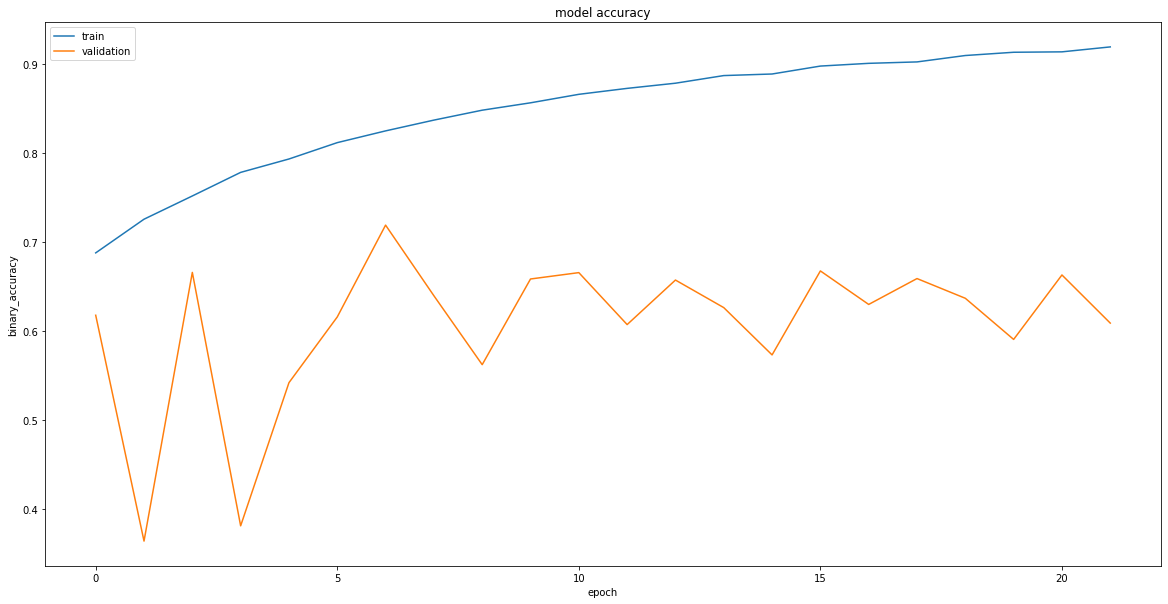

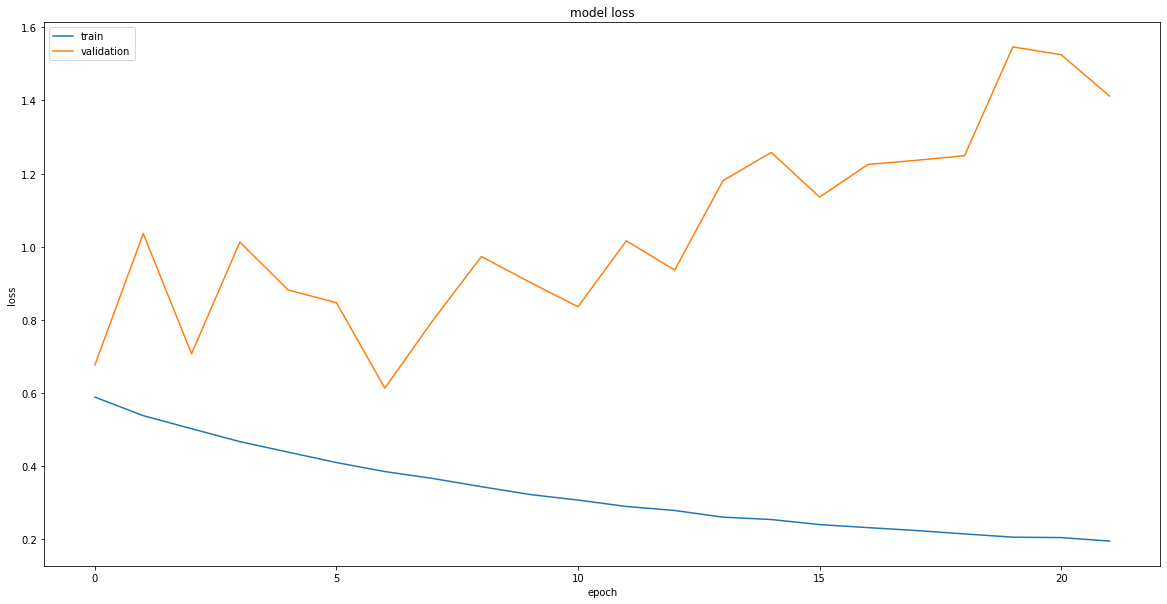

In [32]:
print(history_lstm.history.keys())
# summarize history for accuracy
plt.plot(history_lstm.history['binary_accuracy'])
plt.plot(history_lstm.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [33]:
pred_lstm = lstm.predict(xt)

In [34]:
pred_lstm_bin = np.where(pred_lstm >= 0.50, 1, 0)

The function above is to transform the model output to the binary labels. The model's prediction returns the prediction fraction for the class labeled as "1". That way we said that each value greater or equal to 0.5 will become 1. This means that, if a sample has a probability greater or equal to 50% to be classified as "1" or "active", it will be labeled as "1". The other are classified has "0" or "inactive".

In [35]:
metrics(yt, pred_lstm_bin.flatten())

METRICS:
Accuracy score:
0.7766108193715096

Recall score:
0.776604147818123

Precison score:
0.7838827554642769

F1-score:
0.7751681751414681

MCC score:
0.5604396404804248

Confusion matrix:
[[5139  860]
 [1820 4178]]

Classification report:
              precision    recall  f1-score   support

           0      0.738     0.857     0.793      5999
           1      0.829     0.697     0.757      5998

    accuracy                          0.777     11997
   macro avg      0.784     0.777     0.775     11997
weighted avg      0.784     0.777     0.775     11997




## Bi-LSTM

Bidirectional Long Short-Term Memory (Bi-LSTM) is a recurrent neural network. This neural network has 3 LSTM layers with 256, 128, and 64 neurons respectively. These layers are provided into a ***bidirectional*** layer that will duplicate the layer provided. This means that the LSTM layer will be duplicated and both put side-by-side. The first layer will receive the input as is, while the second layer will receive a reversed copy of the input. After each of these bidirectional layers, there is a 10% dropout layer. Lastly,  dense layer with sigmoid as the activation function, functions as the output layer.
This neural network was compiled in order to use ***binary crossentropy*** as the loss function, the ***binary accuracy*** function as metric, and the ***Adam*** optimizer as the training algorithm.

To note that the input data shape had to be transformed in order for this model to work. That way, the reshaped data has the following shape: (sample size, 1, features size).

In [36]:
bilstm = Sequential()
bilstm.add(Bidirectional(LSTM(256, return_sequences = True), input_shape=(x.shape[1], x.shape[2])))
bilstm.add(Dropout(0.1))
bilstm.add(Bidirectional(LSTM(128, return_sequences = True)))
bilstm.add(Dropout(0.1))
bilstm.add(Bidirectional(LSTM(64, return_sequences = True)))
bilstm.add(Dropout(0.1))
bilstm.add(Dense(1, activation='sigmoid'))
# Compile model
bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [37]:
bilstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 512)           946176    
 l)                                                              
                                                                 
 dropout_5 (Dropout)         (None, 1, 512)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 256)           656384    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 1, 256)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 128)           164352    
 nal)                                                            
                                                      

In [38]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_bilstm = bilstm.fit(x, y, validation_split=0.15, epochs=100, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27993, 205)
Train labels size: (27993,)
Epoch 1/100
744/744 [==============================] - 17s 12ms/step - loss: 0.5797 - binary_accuracy: 0.6962 - val_loss: 0.8054 - val_binary_accuracy: 0.5292
Epoch 2/100
744/744 [==============================] - 7s 9ms/step - loss: 0.5286 - binary_accuracy: 0.7352 - val_loss: 0.8207 - val_binary_accuracy: 0.5108
Epoch 3/100
744/744 [==============================] - 7s 9ms/step - loss: 0.4788 - binary_accuracy: 0.7715 - val_loss: 0.9040 - val_binary_accuracy: 0.5218
Epoch 4/100
744/744 [==============================] - 7s 9ms/step - loss: 0.4335 - binary_accuracy: 0.7963 - val_loss: 0.7420 - val_binary_accuracy: 0.6199
Epoch 5/100
744/744 [==============================] - 7s 9ms/step - loss: 0.3880 - binary_accuracy: 0.8222 - val_loss: 0.8420 - val_binary_accuracy: 0.6054
Epoch 6/100
744/744 [==============================] - 7s 9ms/step - loss: 0.3467 - binary_accuracy: 0.8450 - val_loss: 0.7696 - val_binary_accuracy: 0.647

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


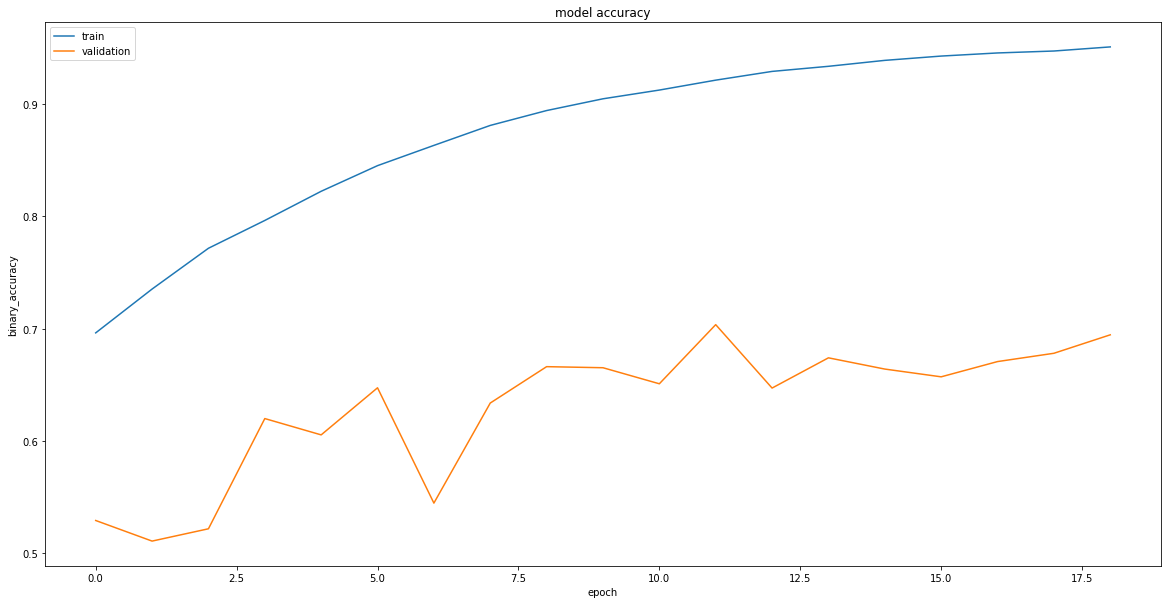

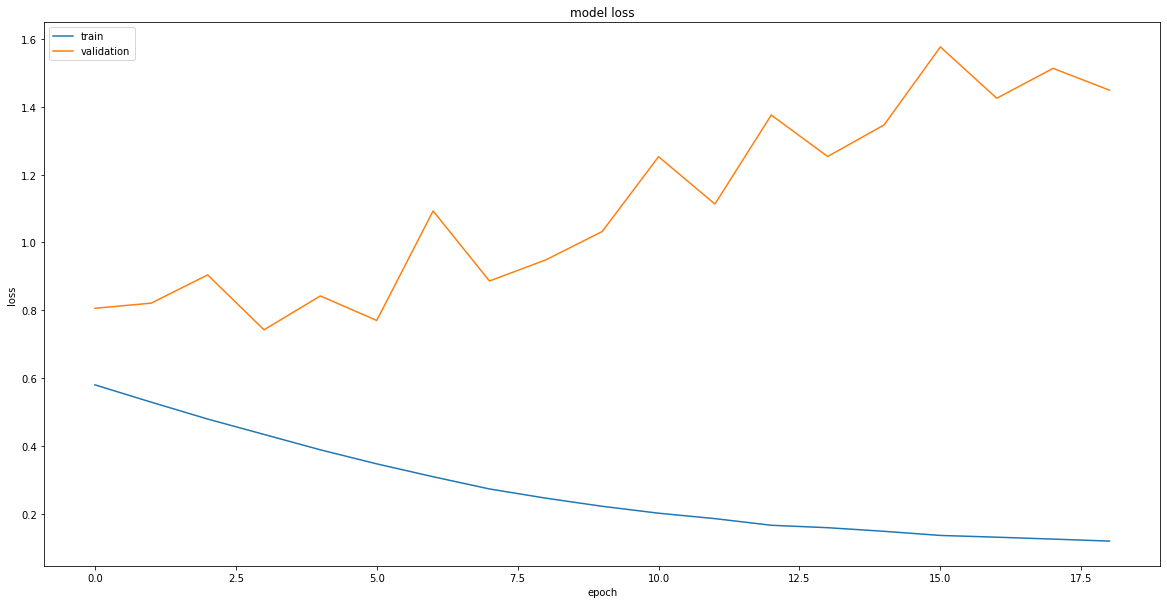

In [39]:
print(history_bilstm.history.keys())
# summarize history for accuracy
plt.plot(history_bilstm.history['binary_accuracy'])
plt.plot(history_bilstm.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [40]:
pred_bilstm = bilstm.predict(xt)

In [41]:
pred_bilstm_bin = np.where(pred_bilstm >= 0.50, 1, 0)

The function above is to transform the model output to the binary labels. The model's prediction returns the prediction fraction for the class labeled as "1". That way we said that each value greater or equal to 0.5 will become 1. This means that, if a sample has a probability greater or equal to 50% to be classified as "1" or "active", it will be labeled as "1". The other are classified has "0" or "inactive".

In [42]:
metrics(yt, pred_bilstm_bin.flatten())

METRICS:
Accuracy score:
0.7909477369342336

Recall score:
0.7909451925437612

Precison score:
0.7920353702108477

F1-score:
0.7907519208819993

MCC score:
0.5829795434338452

Confusion matrix:
[[4928 1071]
 [1437 4561]]

Classification report:
              precision    recall  f1-score   support

           0      0.774     0.821     0.797      5999
           1      0.810     0.760     0.784      5998

    accuracy                          0.791     11997
   macro avg      0.792     0.791     0.791     11997
weighted avg      0.792     0.791     0.791     11997




## Results

| Model | Accuracy | Recall | Precision | F1-score | MCC |
| :-: | :-: | :-: | :-: | :-: | :-: |
| **DNN** | 0.770 | 0.770 | 0.771 | 0.770 | 0.541 |
| **CNN** | 0.785 | 0.785 | 0.788 | 0.785 | 0.573 |
| **LSTM** | 0.777 | 0.777 | 0.784 | 0.775 | 0.560 |
| **Bi-LSTM** | **0.791** | **0.791** | **0.792** | **0.791** | **0.583** |

Observing the metrics when predicting the test set labels, it is clear that the Bi-LSTM model was the best at predicting the compound's activity using fingerprints.

# Descriptors

In [43]:
des_path = '/home/laptop16/Desktop/Mestrado/2_ano/SIB/Grupo/CODE_SIB/src/smiles/dataset/binary_class/descriptors_all.csv'

des = ['MaxEStateIndex','MinEStateIndex','MaxAbsEStateIndex','MinAbsEStateIndex','qed','MolWt','HeavyAtomMolWt','ExactMolWt','NumValenceElectrons','NumRadicalElectrons','MaxPartialCharge','MinPartialCharge','MaxAbsPartialCharge','MinAbsPartialCharge','FpDensityMorgan1','FpDensityMorgan2','FpDensityMorgan3','BCUT2D_MWHI','BCUT2D_MWLOW','BCUT2D_CHGHI','BCUT2D_CHGLO','BCUT2D_LOGPHI','BCUT2D_LOGPLOW','BCUT2D_MRHI','BCUT2D_MRLOW','BalabanJ','BertzCT','Chi0','Chi0n','Chi0v','Chi1','Chi1n','Chi1v','Chi2n','Chi2v','Chi3n','Chi3v','Chi4n','Chi4v','HallKierAlpha','Ipc','Kappa1','Kappa2','Kappa3','LabuteASA','PEOE_VSA1','PEOE_VSA10','PEOE_VSA11','PEOE_VSA12','PEOE_VSA13','PEOE_VSA14','PEOE_VSA2','PEOE_VSA3','PEOE_VSA4','PEOE_VSA5','PEOE_VSA6','PEOE_VSA7','PEOE_VSA8','PEOE_VSA9','SMR_VSA1','SMR_VSA10','SMR_VSA2','SMR_VSA3','SMR_VSA4','SMR_VSA5','SMR_VSA6','SMR_VSA7','SMR_VSA8','SMR_VSA9','SlogP_VSA1','SlogP_VSA10','SlogP_VSA11','SlogP_VSA12','SlogP_VSA2','SlogP_VSA3','SlogP_VSA4','SlogP_VSA5','SlogP_VSA6','SlogP_VSA7','SlogP_VSA8','SlogP_VSA9','TPSA','EState_VSA1','EState_VSA10','EState_VSA11','EState_VSA2','EState_VSA3','EState_VSA4','EState_VSA5','EState_VSA6','EState_VSA7','EState_VSA8','EState_VSA9','VSA_EState1','VSA_EState10','VSA_EState2','VSA_EState3','VSA_EState4','VSA_EState5','VSA_EState6','VSA_EState7','VSA_EState8','VSA_EState9','FractionCSP3','HeavyAtomCount','NHOHCount','NOCount','NumAliphaticCarbocycles','NumAliphaticHeterocycles','NumAliphaticRings','NumAromaticCarbocycles','NumAromaticHeterocycles','NumAromaticRings','NumHAcceptors','NumHDonors','NumHeteroatoms','NumRotatableBonds','NumSaturatedCarbocycles','NumSaturatedHeterocycles','NumSaturatedRings','RingCount','MolLogP','MolMR','fr_Al_COO','fr_Al_OH','fr_Al_OH_noTert','fr_ArN','fr_Ar_COO','fr_Ar_N','fr_Ar_NH','fr_Ar_OH','fr_COO','fr_COO2','fr_C_O','fr_C_O_noCOO','fr_C_S','fr_HOCCN','fr_Imine','fr_NH0','fr_NH1','fr_NH2','fr_N_O','fr_Ndealkylation1','fr_Ndealkylation2','fr_Nhpyrrole','fr_SH','fr_aldehyde','fr_alkyl_carbamate','fr_alkyl_halide','fr_allylic_oxid','fr_amide','fr_amidine','fr_aniline','fr_aryl_methyl','fr_azide','fr_azo','fr_barbitur','fr_benzene','fr_benzodiazepine','fr_bicyclic','fr_diazo','fr_dihydropyridine','fr_epoxide','fr_ester','fr_ether','fr_furan','fr_guanido','fr_halogen','fr_hdrzine','fr_hdrzone','fr_imidazole','fr_imide','fr_isocyan','fr_isothiocyan','fr_ketone','fr_ketone_Topliss','fr_lactam','fr_lactone','fr_methoxy','fr_morpholine','fr_nitrile','fr_nitro','fr_nitro_arom','fr_nitro_arom_nonortho','fr_nitroso','fr_oxazole','fr_oxime','fr_para_hydroxylation','fr_phenol','fr_phenol_noOrthoHbond','fr_phos_acid','fr_phos_ester','fr_piperdine','fr_piperzine','fr_priamide','fr_prisulfonamd','fr_pyridine','fr_quatN','fr_sulfide','fr_sulfonamd','fr_sulfone','fr_term_acetylene','fr_tetrazole','fr_thiazole','fr_thiocyan','fr_thiophene','fr_unbrch_alkane','fr_urea']

des_loader = CSVLoader(des_path, mols_field='smiles', labels_fields='activity', features_fields=des)

In [44]:
des_dataset = des_loader.create_dataset()
des_dataset.get_shape()

Mols_shape:  39989
Features_shape:  (39989, 208)
Labels_shape:  (39989,)


## Standardize data

In [45]:
StandardScaler().fit_transform(des_dataset)

## Data split

In [46]:
splitter = SingletaskStratifiedSplitter()
des_train_dataset, des_test_dataset = splitter.train_test_split(dataset=des_dataset, frac_train=0.7)

des_input_dim = des_train_dataset.X.shape[1]

(27986, 208)
X not defined!
Defined features extracted!
(11994, 208)


## DNN

Dense Neural Network build with 2 dense hidden layers, a dense visible layer that functions as the input, and a final output layer.
The first layer, the input one, is a dense layer with 126 neurons. The second and third layers have 64 and 16 neurons respectively. These three layers have as activation function the ***rectified linear activation*** function, or ReLu. Between the first, second, and third layers the is a dropout layer with a dropout value of 0.1. This means that this layer drops 10% of the neurons output. The last layer has the purpose to provide the output and it has only one neuron. Since this is binary classification task, the activation function is the sigmoid function.

This neural network was compiled in order to use ***binary crossentropy*** as the loss function, the ***binary accuracy*** function as metric, and the ***Adam*** optimizer as the training algorithm.

In [47]:
dnn2 = Sequential()
dnn2.add(Dense(126, input_dim=des_input_dim, activation='relu'))
dnn2.add(Dropout(0.1))
dnn2.add(Dense(64, activation='relu'))
dnn2.add(Dropout(0.1))
dnn2.add(Dense(16, activation='relu'))
dnn2.add(Dense(1, activation='sigmoid'))
# Compile model
dnn2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [48]:
dnn2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 126)               26334     
                                                                 
 dropout_8 (Dropout)         (None, 126)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8128      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 16)                1040      
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 35,519
Trainable params: 35,519
Non-trai

In [49]:
print(f'Train data size: {des_train_dataset.X.shape}\nTrain labels size: {des_train_dataset.y.shape}')
history_dnn2 = dnn2.fit(des_train_dataset.X, des_train_dataset.y, validation_split=0.15, epochs=100, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27986, 208)
Train labels size: (27986,)
Epoch 1/100
744/744 [==============================] - 3s 3ms/step - loss: 0.4895 - binary_accuracy: 0.7677 - val_loss: 0.6313 - val_binary_accuracy: 0.6810
Epoch 2/100
744/744 [==============================] - 2s 3ms/step - loss: 0.4325 - binary_accuracy: 0.8012 - val_loss: 0.6446 - val_binary_accuracy: 0.6756
Epoch 3/100
744/744 [==============================] - 2s 3ms/step - loss: 0.4130 - binary_accuracy: 0.8137 - val_loss: 0.6133 - val_binary_accuracy: 0.6863
Epoch 4/100
744/744 [==============================] - 2s 3ms/step - loss: 0.3976 - binary_accuracy: 0.8210 - val_loss: 0.6255 - val_binary_accuracy: 0.6777
Epoch 5/100
744/744 [==============================] - 2s 3ms/step - loss: 0.3819 - binary_accuracy: 0.8340 - val_loss: 0.6323 - val_binary_accuracy: 0.6932
Epoch 6/100
744/744 [==============================] - 2s 3ms/step - loss: 0.3721 - binary_accuracy: 0.8381 - val_loss: 0.4534 - val_binary_accuracy: 0.7870


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


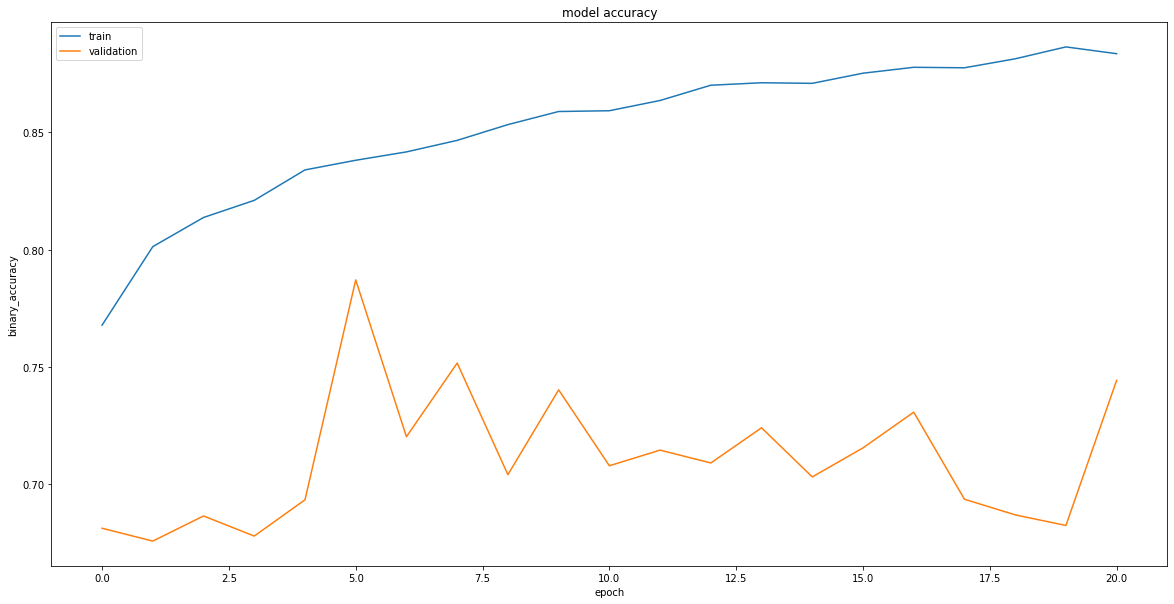

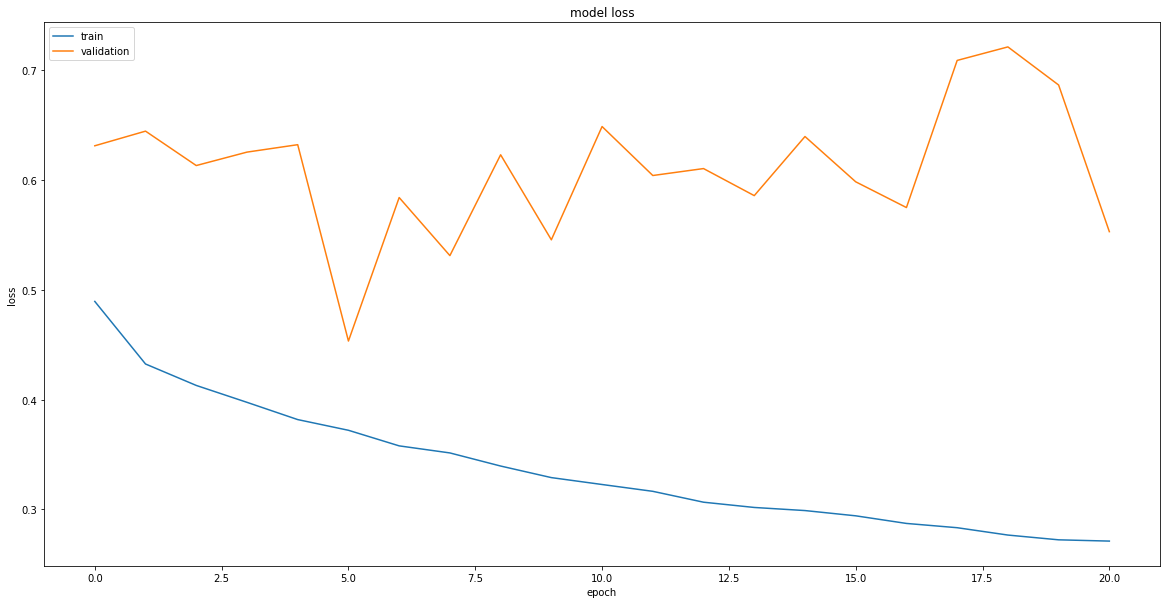

In [50]:
print(history_dnn2.history.keys())
# summarize history for accuracy
plt.plot(history_dnn2.history['binary_accuracy'])
plt.plot(history_dnn2.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_dnn2.history['loss'])
plt.plot(history_dnn2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [51]:
pred_dnn2 = dnn2.predict(des_test_dataset.X)

In [52]:
pred_dnn2_bin= np.where(pred_dnn2 >= 0.50, 1,0)

The function above is to transform the model output to the binary labels. The model's prediction returns the prediction fraction for the class labeled as "1". That way we said that each value greater or equal to 0.5 will become 1. This means that, if a sample has a probability greater or equal to 50% to be classified as "1" or "active", it will be labeled as "1". The other are classified has "0" or "inactive".

In [53]:
metrics(des_test_dataset.y, pred_dnn2_bin)

METRICS:
Accuracy score:
0.8142404535601134

Recall score:
0.8142238051629678

Precison score:
0.8174009561676046

F1-score:
0.8137713038025269

MCC score:
0.6316167705479299

Confusion matrix:
[[5184  815]
 [1413 4582]]

Classification report:
              precision    recall  f1-score   support

           0      0.786     0.864     0.823      5999
           1      0.849     0.764     0.804      5995

    accuracy                          0.814     11994
   macro avg      0.817     0.814     0.814     11994
weighted avg      0.817     0.814     0.814     11994




## CNN

This Convolutional Neural Network begins with a normalization layer. This layer adds ***Gaussian noise*** by applying a 0.05 standard deviation on the noise distribution. After this, there is a reshape layer that will transform the output to be in the shape (None, input dimension, 1). Then, the first real learning layers appears. They are two ***1D Convolutional*** (Conv1D) layers with ReLu activation function and ***same*** padding. The first of these layers has a filter value of 8 and the second has a filter valuo of 16. Both have a kernel size of 32. Then the Conv1D output is flatten and followed by a dropout layer with a value of 0.2. Lastly, there are two final dense layers. The second to last has 128 neurons and has the same activation funtion as the ones before. The final layer serves as the output layer and it has 1 neuron and the sigmoid activation function.
This neural network was compiled in order to use ***binary crossentropy*** as the loss function, the ***binary accuracy*** function as metric, and the ***Adam*** optimizer as the training algorithm.

In [54]:
g_noise = 0.05
C1_K=8
C1_S=32
C2_K=16
C2_S=32

In [55]:
cnn2 = Sequential()
#Adding a bit of GaussianNoise also works as regularization
cnn2.add(GaussianNoise(g_noise, input_shape=(des_input_dim,)))
#First two is number of filter + kernel size
cnn2.add(Reshape((des_input_dim, 1)))
cnn2.add(Conv1D(C1_K, (C1_S), activation='relu', padding="same"))
cnn2.add(Conv1D(C2_K, (C2_S), padding="same", activation='relu'))
cnn2.add(Flatten())
cnn2.add(Dropout(0.2))
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dense(1, activation='sigmoid'))
cnn2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [56]:
cnn2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_1 (GaussianN  (None, 208)              0         
 oise)                                                           
                                                                 
 reshape_1 (Reshape)         (None, 208, 1)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 208, 8)            264       
                                                                 
 conv1d_3 (Conv1D)           (None, 208, 16)           4112      
                                                                 
 flatten_1 (Flatten)         (None, 3328)              0         
                                                                 
 dropout_10 (Dropout)        (None, 3328)              0         
                                                      

In [57]:
print(f'Train data size: {des_train_dataset.X.shape}\nTrain labels size: {des_train_dataset.y.shape}')
history_cnn2 = cnn2.fit(des_train_dataset.X, des_train_dataset.y, validation_split=0.15, epochs=100, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27986, 208)
Train labels size: (27986,)
Epoch 1/100
744/744 [==============================] - 4s 4ms/step - loss: 0.4748 - binary_accuracy: 0.7777 - val_loss: 0.6615 - val_binary_accuracy: 0.6667
Epoch 2/100
744/744 [==============================] - 3s 4ms/step - loss: 0.4237 - binary_accuracy: 0.8078 - val_loss: 0.5185 - val_binary_accuracy: 0.7363
Epoch 3/100
744/744 [==============================] - 3s 4ms/step - loss: 0.3908 - binary_accuracy: 0.8255 - val_loss: 0.5633 - val_binary_accuracy: 0.7218
Epoch 4/100
744/744 [==============================] - 3s 4ms/step - loss: 0.3583 - binary_accuracy: 0.8429 - val_loss: 0.5519 - val_binary_accuracy: 0.7349
Epoch 5/100
744/744 [==============================] - 3s 4ms/step - loss: 0.3213 - binary_accuracy: 0.8630 - val_loss: 0.4880 - val_binary_accuracy: 0.7716
Epoch 6/100
744/744 [==============================] - 3s 4ms/step - loss: 0.2855 - binary_accuracy: 0.8795 - val_loss: 0.5519 - val_binary_accuracy: 0.7611


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


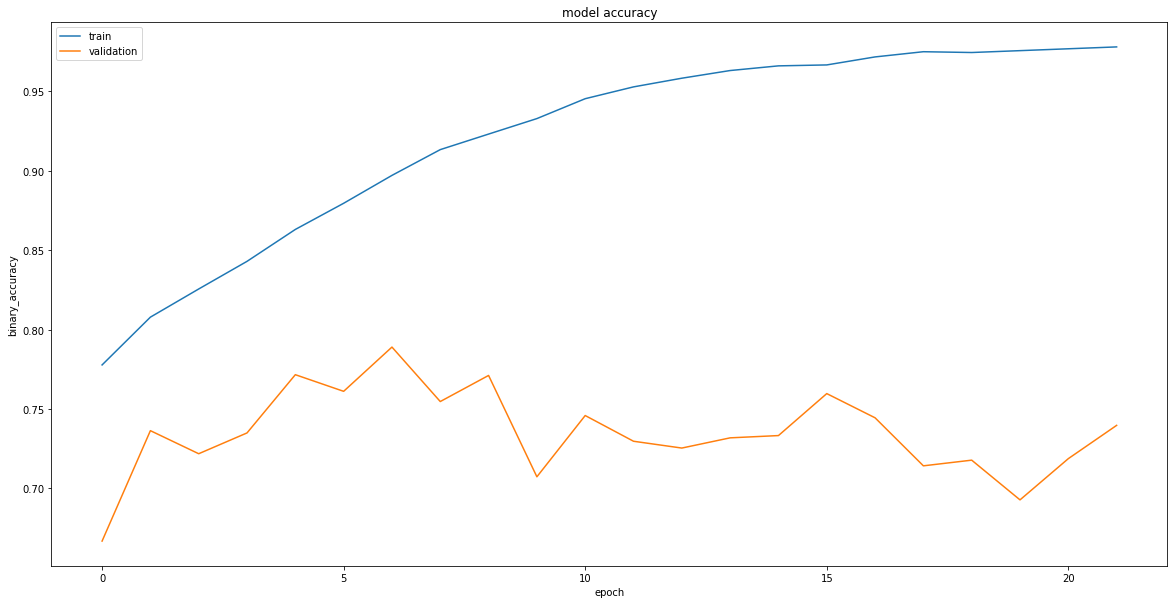

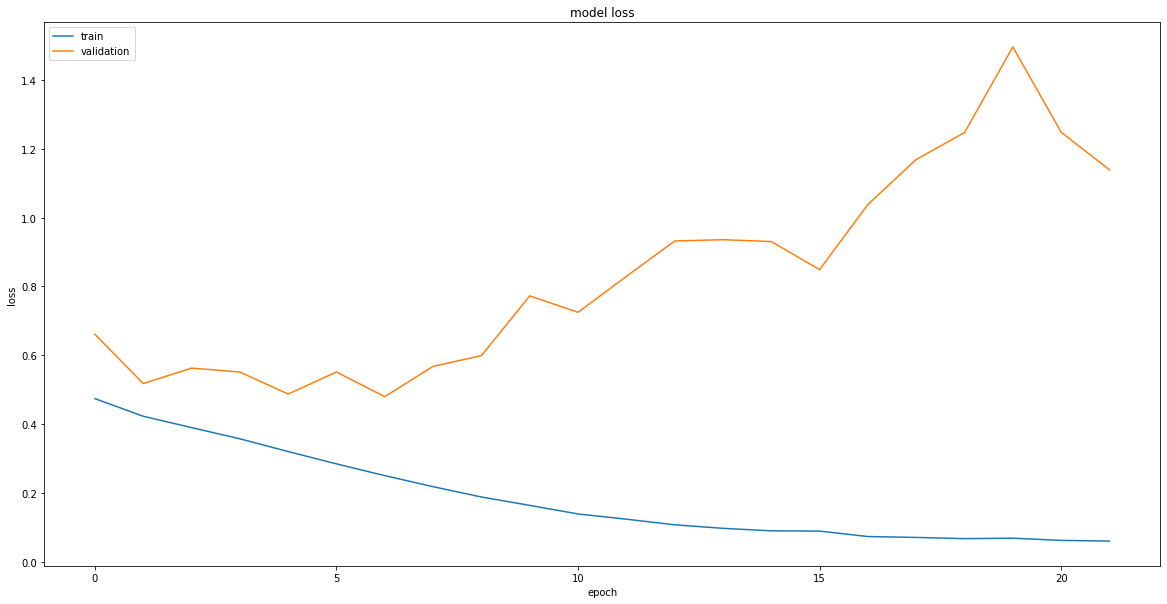

In [58]:
print(history_cnn2.history.keys())
# summarize history for accuracy
plt.plot(history_cnn2.history['binary_accuracy'])
plt.plot(history_cnn2.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_cnn2.history['loss'])
plt.plot(history_cnn2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [59]:
pred_cnn2 = cnn2.predict(des_test_dataset.X)

In [60]:
pred_cnn2_bin = np.where(pred_cnn2 >= 0.50, 1, 0)

The function above is to transform the model output to the binary labels. The model's prediction returns the prediction fraction for the class labeled as "1". That way we said that each value greater or equal to 0.5 will become 1. This means that, if a sample has a probability greater or equal to 50% to be classified as "1" or "active", it will be labeled as "1". The other are classified has "0" or "inactive".

In [61]:
metrics(des_test_dataset.y, pred_cnn2_bin)

METRICS:
Accuracy score:
0.8140737035184259

Recall score:
0.814057221936211

Precison score:
0.8171688700060512

F1-score:
0.8136134692470747

MCC score:
0.631218422414136

Confusion matrix:
[[5180  819]
 [1411 4584]]

Classification report:
              precision    recall  f1-score   support

           0      0.786     0.863     0.823      5999
           1      0.848     0.765     0.804      5995

    accuracy                          0.814     11994
   macro avg      0.817     0.814     0.814     11994
weighted avg      0.817     0.814     0.814     11994




## LSTM

Long Short-Term Memory (LSTM) is a recurrent neural network. This neural network has a LSTM layer as the visible layer. It has 128 neurons. This layer is followed by a 20% dropout layer. A second LSTM layer is added, with 64 neurons. After these, a 128 neuron deep dense layer appears followed, again, by a 20% dropout layer. Finally, a dense layer with sigmoid as the activation function, functions as the output layer.
This neural network was compiled in order to use ***binary crossentropy*** as the loss function, the ***binary accuracy*** function as metric, and the ***Adam*** optimizer as the training algorithm.

To note that the input data shape had to be transformed in order for this model to work. That way, the reshaped data has the following shape: (sample size, 1, features size).

### Reshape data

In [62]:
xx = np.reshape(des_train_dataset.X, (-1, 1, des_train_dataset.X.shape[1]))
yy = np.reshape(des_train_dataset.y, (-1, 1,))
xxt = np.reshape(des_test_dataset.X, (-1, 1, des_test_dataset.X.shape[1]))
yyt = np.reshape(des_test_dataset.y, (-1, 1,))

In [63]:
xx.shape

(27986, 1, 208)

In [64]:
yy.shape

(27986, 1)

In [65]:
lstm2 = Sequential()
lstm2.add(LSTM(128, input_shape=(xx.shape[1], xx.shape[2]), activation='relu', return_sequences=True))
lstm2.add(Dropout(0.2))
lstm2.add(LSTM(64, return_sequences=True))
lstm2.add(Dense(128, activation='relu'))
lstm2.add(Dropout(0.2))
lstm2.add(Dense(1, activation='sigmoid'))
# Compile model
lstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [66]:
lstm2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1, 128)            172544    
                                                                 
 dropout_11 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_6 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dense_15 (Dense)            (None, 1, 128)            8320      
                                                                 
 dropout_12 (Dropout)        (None, 1, 128)            0         
                                                                 
 dense_16 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 230,401
Trainable params: 230,401
Non-tr

In [67]:
print(f'Train data size: {xx.shape}\nTrain labels size: {yy.shape}')
history_lstm2 = lstm2.fit(xx, yy, validation_split=0.15, epochs=100, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27986, 1, 208)
Train labels size: (27986, 1)
Epoch 1/100
744/744 [==============================] - 8s 8ms/step - loss: 0.4675 - binary_accuracy: 0.7829 - val_loss: 0.6865 - val_binary_accuracy: 0.6594
Epoch 2/100
744/744 [==============================] - 5s 7ms/step - loss: 0.4152 - binary_accuracy: 0.8125 - val_loss: 0.5337 - val_binary_accuracy: 0.7287
Epoch 3/100
744/744 [==============================] - 5s 7ms/step - loss: 0.3851 - binary_accuracy: 0.8292 - val_loss: 0.4899 - val_binary_accuracy: 0.7651
Epoch 4/100
744/744 [==============================] - 5s 7ms/step - loss: 0.3622 - binary_accuracy: 0.8413 - val_loss: 0.4896 - val_binary_accuracy: 0.7537
Epoch 5/100
744/744 [==============================] - 5s 7ms/step - loss: 0.3395 - binary_accuracy: 0.8526 - val_loss: 0.4833 - val_binary_accuracy: 0.7580
Epoch 6/100
744/744 [==============================] - 5s 7ms/step - loss: 0.3246 - binary_accuracy: 0.8602 - val_loss: 0.5277 - val_binary_accuracy: 0.

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


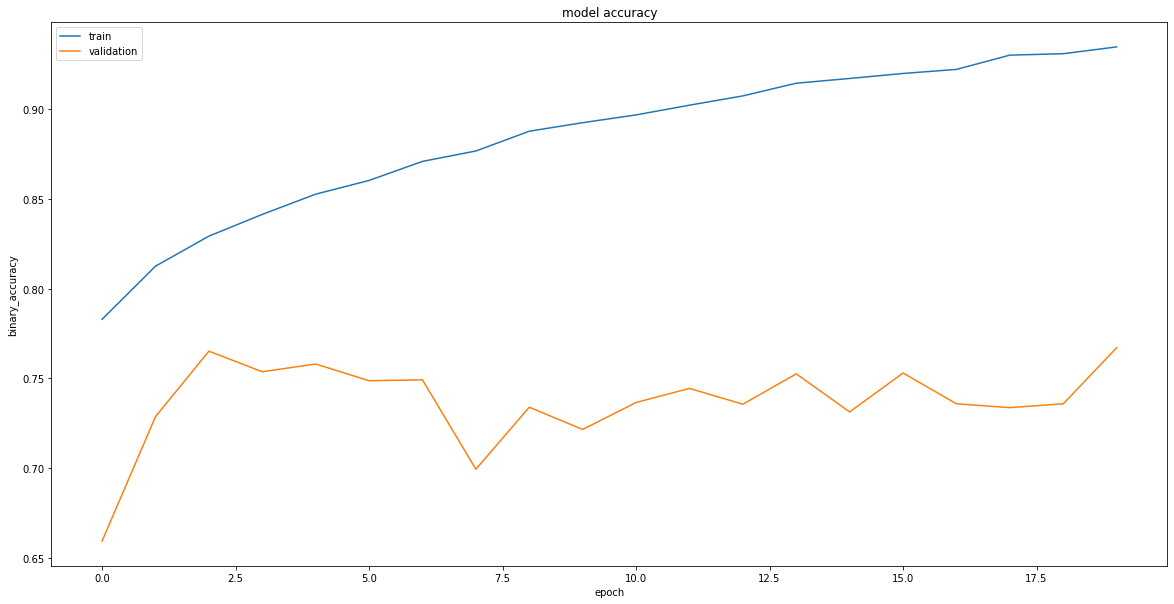

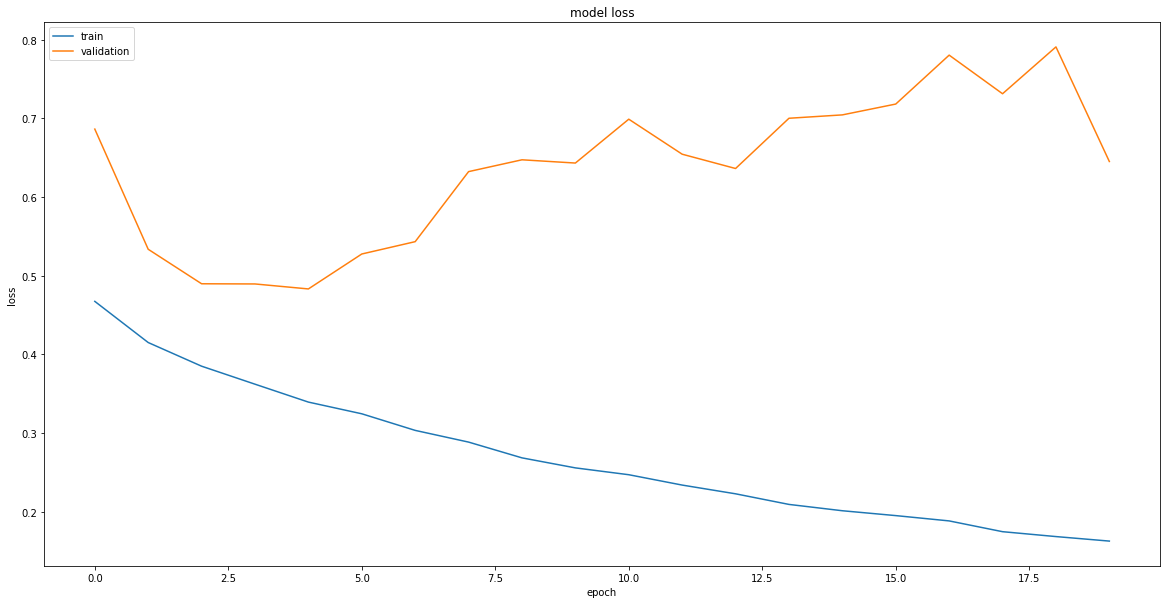

In [68]:
print(history_lstm2.history.keys())
# summarize history for accuracy
plt.plot(history_lstm2.history['binary_accuracy'])
plt.plot(history_lstm2.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm2.history['loss'])
plt.plot(history_lstm2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [69]:
pred_lstm2 = lstm2.predict(xxt)

In [70]:
pred_lstm2_bin = np.where(pred_lstm2 >= 0.50, 1, 0)

The function above is to transform the model output to the binary labels. The model's prediction returns the prediction fraction for the class labeled as "1". That way we said that each value greater or equal to 0.5 will become 1. This means that, if a sample has a probability greater or equal to 50% to be classified as "1" or "active", it will be labeled as "1". The other are classified has "0" or "inactive".

In [71]:
metrics(yyt, pred_lstm2_bin.flatten())

METRICS:
Accuracy score:
0.8239119559779889

Recall score:
0.8239023712737221

Precison score:
0.8249841334574517

F1-score:
0.8237635928335083

MCC score:
0.6488856030247685

Confusion matrix:
[[5115  884]
 [1228 4767]]

Classification report:
              precision    recall  f1-score   support

           0      0.806     0.853     0.829      5999
           1      0.844     0.795     0.819      5995

    accuracy                          0.824     11994
   macro avg      0.825     0.824     0.824     11994
weighted avg      0.825     0.824     0.824     11994




## Bi-LSTM

Bidirectional Long Short-Term Memory (Bi-LSTM) is a recurrent neural network. This neural network has 3 LSTM layers with 256, 128, and 64 neurons respectively. These layers are provided into a ***bidirectional*** layer that will duplicate the layer provided. This means that the LSTM layer will be duplicated and both put side-by-side. The first layer will receive the input as is, while the second layer will receive a reversed copy of the input. After each of these bidirectional layers, there is a 10% dropout layer. Lastly,  dense layer with sigmoid as the activation function, functions as the output layer.
This neural network was compiled in order to use ***binary crossentropy*** as the loss function, the ***binary accuracy*** function as metric, and the ***Adam*** optimizer as the training algorithm.

To note that the input data shape had to be transformed in order for this model to work. That way, the reshaped data has the following shape: (sample size, 1, features size).

In [72]:
bilstm2 = Sequential()
bilstm2.add(Bidirectional(LSTM(256, return_sequences = True), input_shape=(xx.shape[1], xx.shape[2])))
bilstm2.add(Dropout(0.1))
bilstm2.add(Bidirectional(LSTM(128, return_sequences = True)))
bilstm2.add(Dropout(0.1))
bilstm2.add(Bidirectional(LSTM(64, return_sequences = True)))
bilstm2.add(Dropout(0.1))
bilstm2.add(Dense(1, activation='sigmoid'))
# Compile model
bilstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [73]:
bilstm2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 1, 512)           952320    
 nal)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 1, 512)            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 1, 256)           656384    
 nal)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 1, 256)            0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 1, 128)           164352    
 nal)                                                            
                                                      

In [74]:
print(f'Train data size: {xx.shape}\nTrain labels size: {yy.shape}')
history_bilstm2 = bilstm2.fit(xx, yy, validation_split=0.15, epochs=100, batch_size=32, verbose=1, callbacks=[early])

Train data size: (27986, 1, 208)
Train labels size: (27986, 1)
Epoch 1/100
744/744 [==============================] - 17s 12ms/step - loss: 0.4600 - binary_accuracy: 0.7886 - val_loss: 0.5451 - val_binary_accuracy: 0.7232
Epoch 2/100
744/744 [==============================] - 7s 9ms/step - loss: 0.4045 - binary_accuracy: 0.8174 - val_loss: 0.6042 - val_binary_accuracy: 0.7127
Epoch 3/100
744/744 [==============================] - 7s 9ms/step - loss: 0.3657 - binary_accuracy: 0.8393 - val_loss: 0.5796 - val_binary_accuracy: 0.7251
Epoch 4/100
744/744 [==============================] - 7s 9ms/step - loss: 0.3309 - binary_accuracy: 0.8543 - val_loss: 0.5852 - val_binary_accuracy: 0.7220
Epoch 5/100
744/744 [==============================] - 6s 9ms/step - loss: 0.2928 - binary_accuracy: 0.8742 - val_loss: 0.5684 - val_binary_accuracy: 0.7399
Epoch 6/100
744/744 [==============================] - 6s 9ms/step - loss: 0.2599 - binary_accuracy: 0.8895 - val_loss: 0.6202 - val_binary_accuracy: 

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


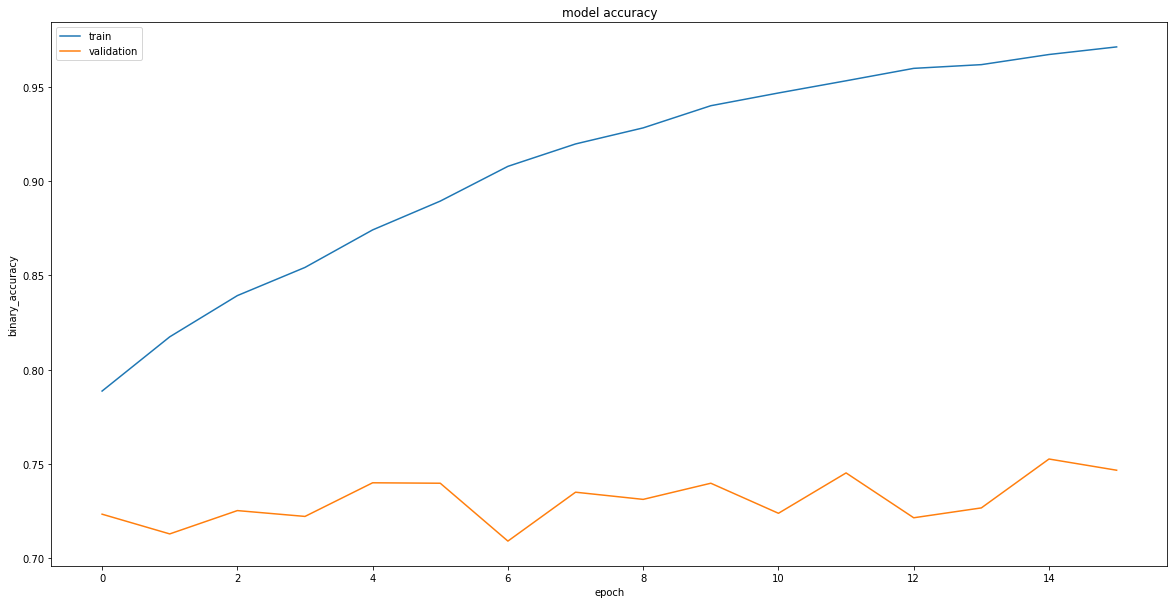

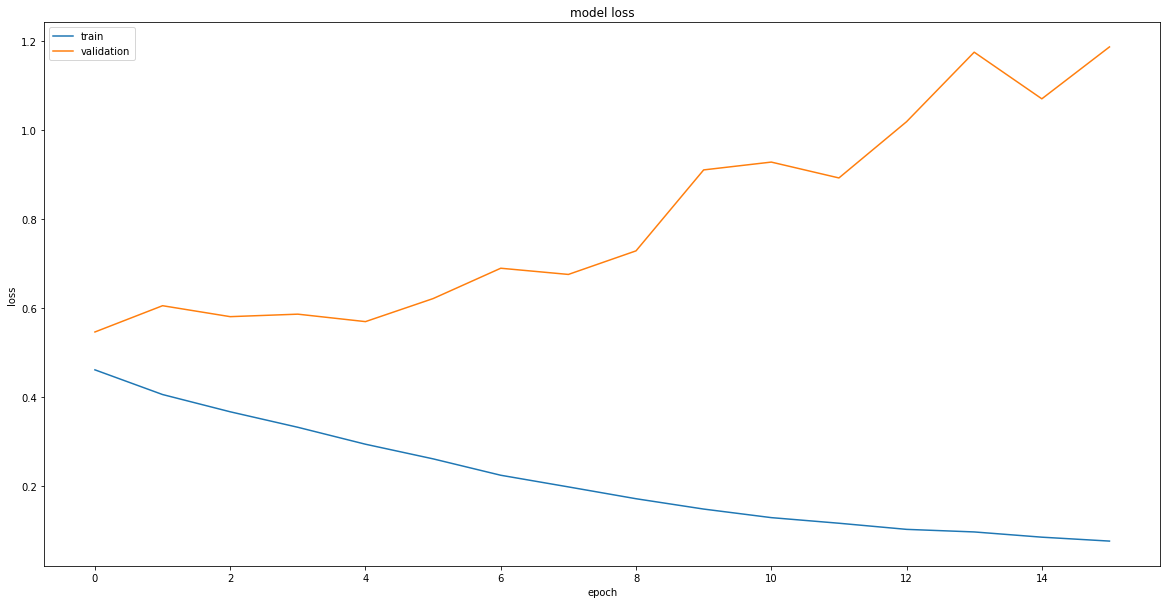

In [75]:
print(history_bilstm2.history.keys())
# summarize history for accuracy
plt.plot(history_bilstm2.history['binary_accuracy'])
plt.plot(history_bilstm2.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_bilstm2.history['loss'])
plt.plot(history_bilstm2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [76]:
pred_bilstm2 = bilstm2.predict(xxt)

In [77]:
pred_bilstm2_bin = np.where(pred_bilstm2 >= 0.50, 1, 0)

The function above is to transform the model output to the binary labels. The model's prediction returns the prediction fraction for the class labeled as "1". That way we said that each value greater or equal to 0.5 will become 1. This means that, if a sample has a probability greater or equal to 50% to be classified as "1" or "active", it will be labeled as "1". The other are classified has "0" or "inactive".

In [78]:
metrics(yyt, pred_bilstm2_bin.flatten())

METRICS:
Accuracy score:
0.8131565782891446

Recall score:
0.813142793746136

Precison score:
0.8153083685639891

F1-score:
0.812832609488804

MCC score:
0.6284474311306041

Confusion matrix:
[[5126  873]
 [1368 4627]]

Classification report:
              precision    recall  f1-score   support

           0      0.789     0.854     0.821      5999
           1      0.841     0.772     0.805      5995

    accuracy                          0.813     11994
   macro avg      0.815     0.813     0.813     11994
weighted avg      0.815     0.813     0.813     11994




## Results

| Model | Accuracy | Recall | Precision | F1-score | MCC |
| :-: | :-: | :-: | :-: | :-: | :-: |
| **DNN** | 0.814 | 0.814 | 0.817 | 0.814 | 0.632 |
| **CNN** | 0.814 | 0.814 | 0.817 | 0.814 | 0.631 |
| **LSTM** | **0.824** | **0.824** | **0.825** | **0.824** | **0.649** |
| **Bi-LSTM** | 0.813 | 0.813 | 0.815 | 0.813 | 0.628 |

Observing the metrics when predicting the test set labels, it is clear that the LSTM model was the best at predicting the compound's activity using descriptors.

# Conclusion

| Data | Model | Accuracy | Recall | Precision | F1-score | MCC |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| **Fingerprints** | Bi-LSTM | 0.791 | 0.791 | 0.792 | 0.791 | 0.583 |
| **Descriptors** | **LSTM** | **0.824** | **0.824** | **0.825** | **0.824** | **0.649** |

Following these results, descriptors where the best at predicting the coumpound's activity with an accuracy improvement of 4.2% over the fingerprints' accuracy. However, it is visible from the training and validation loss graphs that all models appear to suffer a bit of overfitting. The training loss is constantly tending to zero, which is expected, but the validation loss often follows a zig-zag pattern with a tendency to rise. This is a sign that the model is overfitting the training set.

To note that these models were built this way based on a trial and error system, since we do not possess the computational power to perform hyperparameter optimization. These models are a product of those tries.